# Virginia Council — New Member Analysis (First-Time Memberships Only)
**Goal:** Identify trends in first-time memberships (not renewals).
**Method:** For each Account ID, keep the earliest "Created On" row, preferring rows **without** `Term` = "(Renew)".
Outputs: New members per month (overall & by level), status distribution, cumulative growth.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 4.5)

CSV_PATH = Path("../data/membership/allmembers.csv")  
assert CSV_PATH.exists(), f"File not found: {CSV_PATH}"


In [5]:
# Expected columns per your export
REQ_COLS = ["Account ID", "Membership Level", "Status", "Created On"]  # 'Term' optional

df = pd.read_csv(CSV_PATH, dtype=str)
missing = [c for c in REQ_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

# Keep only columns we need (plus 'Term' if present)
keep_cols = REQ_COLS + (["Term"] if "Term" in df.columns else [])
df = df[keep_cols].copy()

# Parse dates & normalize a few text fields
df["Created On"] = pd.to_datetime(df["Created On"], errors="coerce")
df = df.dropna(subset=["Created On"]).copy()
df["Membership Level"] = df["Membership Level"].astype(str).str.strip()
df["Status"] = df["Status"].astype(str).str.strip().str.title()

# Flag renewals via Term (if present)
if "Term" in df.columns:
    df["Term"] = df["Term"].astype(str)
    df["_is_renewal_row"] = df["Term"].str.contains("(Renew)", case=False, regex=False)
else:
    df["_is_renewal_row"] = False

df.head()


,Account ID,Membership Level,Status,Created On,Term,_is_renewal_row
0,12548,Freedom Membership,Succeeded,2025-10-27,Freedom Membership (Renew),True
1,14049,Freedom Membership,Succeeded,2025-10-26,Freedom Membership,False
2,12543,President’s Council Membership,Succeeded,2025-10-24,President’s Council Member (Renew),True
3,12514,Freedom Membership,Succeeded,2025-10-23,Freedom Membership (Renew),True
4,12585,President’s Council Membership,Succeeded,2025-10-23,President’s Council Member (Renew),True


In [6]:
# Earliest non-renewal per account (preferred)
nonrenew = df[~df["_is_renewal_row"]]
if not nonrenew.empty:
    earliest_nonrenew = (nonrenew
        .sort_values(["Account ID", "Created On"])
        .groupby("Account ID", as_index=False)
        .first()
    )
else:
    earliest_nonrenew = pd.DataFrame(columns=df.columns)

# Earliest overall per account (fallback)
earliest_overall = (df
    .sort_values(["Account ID", "Created On"])
    .groupby("Account ID", as_index=False)
    .first()
)

# Prefer earliest_nonrenew where available
first_time = earliest_overall.set_index("Account ID")
if not earliest_nonrenew.empty:
    first_time.loc[earliest_nonrenew.set_index("Account ID").index] = earliest_nonrenew.set_index("Account ID")
first_time = first_time.reset_index().sort_values("Created On")

print(f"Original rows: {len(df):,}")
print(f"Unique accounts: {df['Account ID'].nunique():,}")
print(f"First-time memberships retained: {len(first_time):,}")

first_time.head(10)


Original rows: 171
Unique accounts: 140
First-time memberships retained: 140


,Account ID,Membership Level,Status,Created On,Term,_is_renewal_row
12,11884,Liberty Membership,Succeeded,2024-08-25,Liberty Member,False
11,11883,Patriot Level Membership,Succeeded,2024-08-25,Patriot Member,False
110,2160,Liberty Membership,Succeeded,2024-08-25,Liberty Member,False
138,8730,Patriot Level Membership,Succeeded,2024-09-01,Patriot Member,False
16,11932,Liberty Membership,Succeeded,2024-09-06,Liberty Member,False
17,11948,President’s Council Membership,Succeeded,2024-09-09,President’s Council Member,False
18,11954,Freedom Membership,Succeeded,2024-09-10,Freedom Membership,False
14,11907,Freedom Membership,Succeeded,2024-09-10,Freedom Membership,False
19,11972,Freedom Membership,Succeeded,2024-09-12,Freedom Membership,False
115,3160,Liberty Membership,Succeeded,2024-09-14,Liberty Member,False


In [7]:
# Month bucket
first_time["Month"] = first_time["Created On"].dt.to_period("M").dt.to_timestamp()

# Overall new members per month
new_per_month = (first_time.groupby("Month")
                 .size()
                 .rename("New_Members")
                 .reset_index()
                 .sort_values("Month"))

# By level
new_per_month_by_level = (first_time.groupby(["Month", "Membership Level"])
                          .size()
                          .rename("New_Members")
                          .reset_index()
                          .sort_values(["Month", "Membership Level"]))

# Status distribution (current status in export for this cohort)
status_distribution = (first_time["Status"].value_counts(dropna=False)
                       .rename_axis("Status")
                       .reset_index(name="Count")
                       .sort_values("Count", ascending=False))

# Cumulative growth
growth = new_per_month.assign(Cumulative_New_Members=lambda d: d["New_Members"].cumsum())

new_per_month.head(), new_per_month_by_level.head(), status_distribution, growth.head()


(       Month  New_Members
 0 2024-08-01            3
 1 2024-09-01           17
 2 2024-10-01           18
 3 2024-11-01           14
 4 2024-12-01           13,
        Month          Membership Level  New_Members
 0 2024-08-01        Liberty Membership            2
 1 2024-08-01  Patriot Level Membership            1
 2 2024-09-01        Freedom Membership            8
 3 2024-09-01        Liberty Membership            6
 4 2024-09-01  Patriot Level Membership            2,
       Status  Count
 0  Succeeded    140,
        Month  New_Members  Cumulative_New_Members
 0 2024-08-01            3                       3
 1 2024-09-01           17                      20
 2 2024-10-01           18                      38
 3 2024-11-01           14                      52
 4 2024-12-01           13                      65)

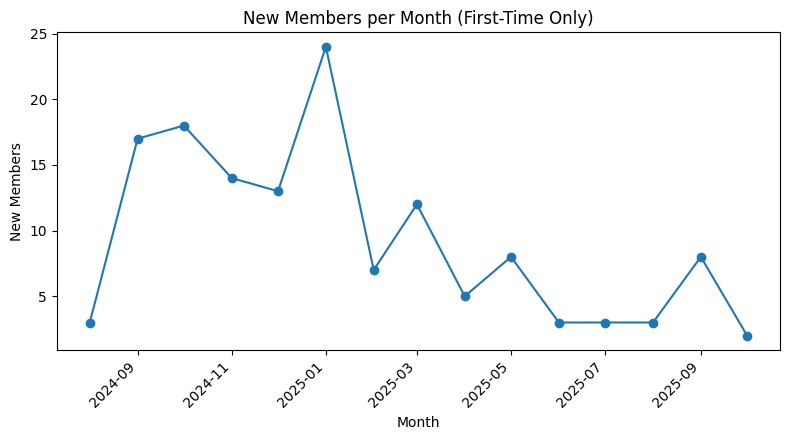

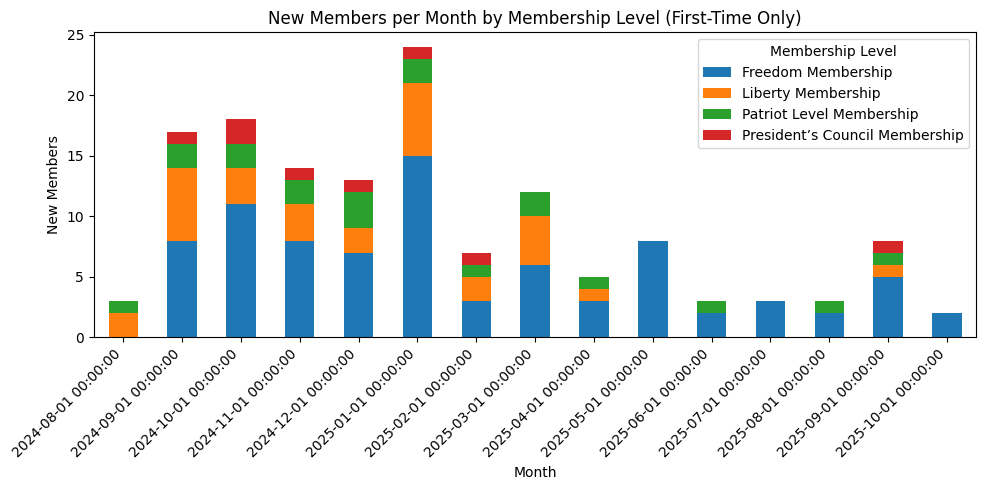

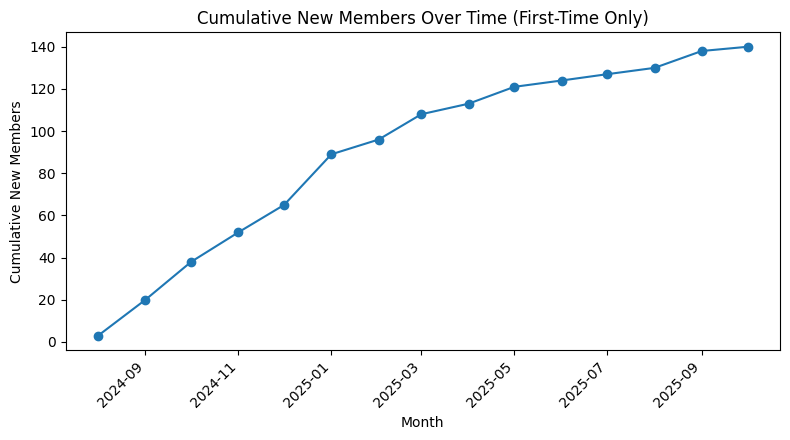

In [9]:
# New members per month (overall)
plt.figure()
plt.plot(new_per_month["Month"], new_per_month["New_Members"], marker="o")
plt.title("New Members per Month (First-Time Only)")
plt.xlabel("Month"); plt.ylabel("New Members")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

# New members per month by level (stacked bar for slides)
pivot_levels = (new_per_month_by_level
                .pivot(index="Month", columns="Membership Level", values="New_Members")
                .fillna(0))
pivot_levels.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("New Members per Month by Membership Level (First-Time Only)")
plt.xlabel("Month"); plt.ylabel("New Members")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()



# Cumulative growth
plt.figure()
plt.plot(growth["Month"], growth["Cumulative_New_Members"], marker="o")
plt.title("Cumulative New Members Over Time (First-Time Only)")
plt.xlabel("Month"); plt.ylabel("Cumulative New Members")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
plt.rcParams["figure.figsize"] = (9, 4.8)

CSV_PATH = Path("../data/membership/allmembers.csv")
assert CSV_PATH.exists(), f"File not found: {CSV_PATH}"

# Load
df = pd.read_csv(CSV_PATH, dtype=str)

# Basic normalization (keep real headers)
df["Created On"] = pd.to_datetime(df["Created On"], errors="coerce")
df = df.dropna(subset=["Created On"]).copy()
df["Membership Level"] = df["Membership Level"].astype(str).str.strip()
df["Status"] = df["Status"].astype(str).str.strip().str.title()
df["Term"] = df["Term"].astype(str)

# Renewals = rows where Term contains "(Renew)"
df["_is_renewal"] = df["Term"].str.contains("(Renew)", case=False, regex=False)

# Convenience month fields
df["Month"] = df["Created On"].dt.to_period("M").dt.to_timestamp()


In [19]:
renewals = df[df["_is_renewal"]].copy()

# Overall renewals per month
renewals_per_month = (renewals.groupby("Month")
                      .size()
                      .rename("Renewals")
                      .reset_index()
                      .sort_values("Month"))

# Renewals per month by membership level (level taken from the renewal row)
renewals_by_level = (renewals.groupby(["Month", "Membership Level"])
                     .size()
                     .rename("Renewals")
                     .reset_index()
                     .sort_values(["Month", "Membership Level"]))

renewals_per_month.head(), renewals_by_level.head()


(       Month  Renewals
 0 2024-09-01         1
 1 2024-11-01         1
 2 2025-01-01         3
 3 2025-03-01         1
 4 2025-06-01         1,
        Month    Membership Level  Renewals
 0 2024-09-01  Freedom Membership         1
 1 2024-11-01  Freedom Membership         1
 2 2025-01-01  Liberty Membership         3
 3 2025-03-01  Freedom Membership         1
 4 2025-06-01  Freedom Membership         1)

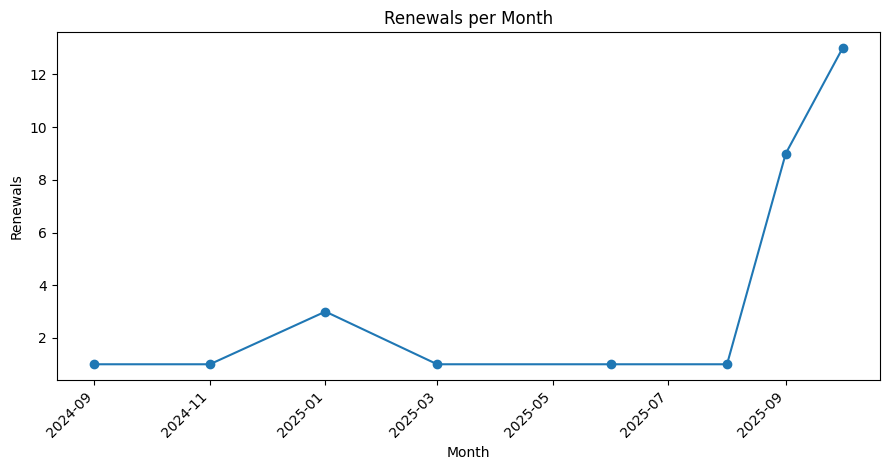

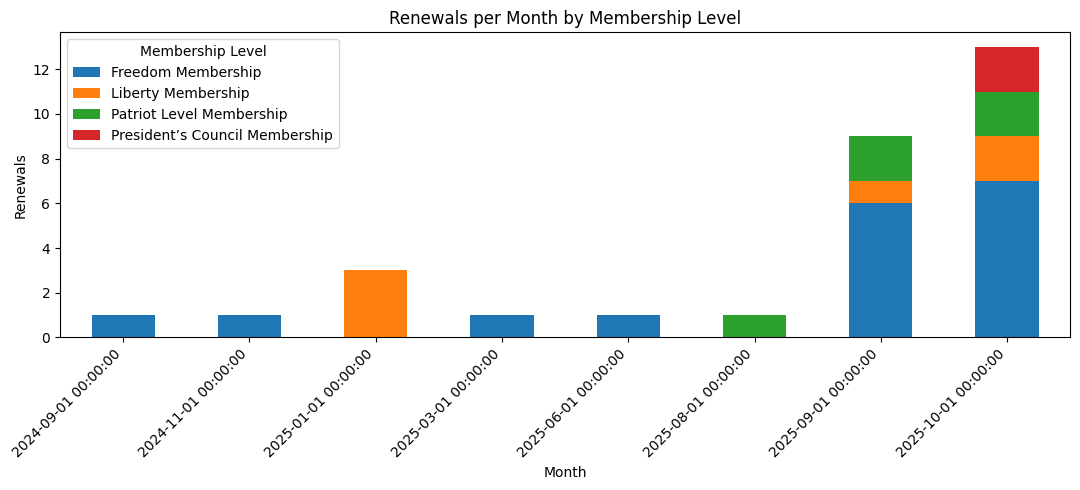

In [20]:
# 1) Renewals per month (line)
plt.figure()
plt.plot(renewals_per_month["Month"], renewals_per_month["Renewals"], marker="o")
plt.title("Renewals per Month")
plt.xlabel("Month"); plt.ylabel("Renewals")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

# 2) Renewals per month by level (stacked bar)
pivot_lvl = (renewals_by_level
             .pivot(index="Month", columns="Membership Level", values="Renewals")
             .fillna(0))
pivot_lvl.plot(kind="bar", stacked=True, figsize=(11,5))
plt.title("Renewals per Month by Membership Level")
plt.xlabel("Month"); plt.ylabel("Renewals")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


,Membership Level,No_Renew_Count
0,Freedom Membership,64
1,Liberty Membership,27
2,Patriot Level Membership,14
3,President’s Council Membership,6


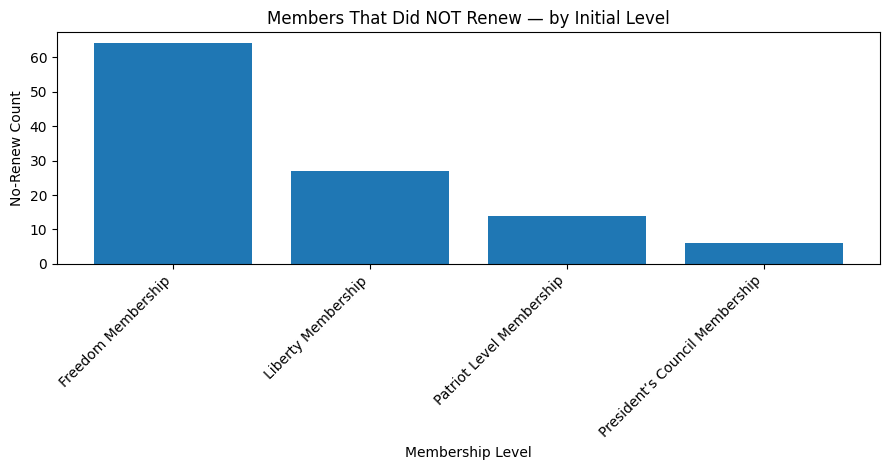

In [22]:
# Initial (first-time) row per account: earliest Created On, ignoring renewal rows if possible
nonrenew_rows = df[~df["_is_renewal"]].copy()
if not nonrenew_rows.empty:
    first_initial = (nonrenew_rows.sort_values(["Account ID", "Created On"])
                                  .groupby("Account ID", as_index=False)
                                  .first())
else:
    # Fallback if all rows were tagged as renewals
    first_initial = (df.sort_values(["Account ID", "Created On"])
                       .groupby("Account ID", as_index=False)
                       .first())

# Accounts that have at least one renewal row
renewed_accounts = set(renewals["Account ID"].unique())

# Accounts that never renewed
never_renewed = first_initial[~first_initial["Account ID"].isin(renewed_accounts)].copy()

# Count by their initial membership level
never_renewed_by_level = (never_renewed["Membership Level"]
                          .value_counts(dropna=False)
                          .rename_axis("Membership Level")
                          .reset_index(name="No_Renew_Count"))

display(never_renewed_by_level)

# Plot
plt.figure()
plt.bar(never_renewed_by_level["Membership Level"].astype(str),
        never_renewed_by_level["No_Renew_Count"])
plt.title("Members That Did NOT Renew — by Initial Level")
plt.xlabel("Membership Level"); plt.ylabel("No-Renew Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

CSV_PATH = Path("../data/membership/allmembers.csv")
assert CSV_PATH.exists(), f"File not found: {CSV_PATH}"

df = pd.read_csv(CSV_PATH, dtype=str)

# Use your real columns directly
df["Created On"] = pd.to_datetime(df["Created On"], errors="coerce")
df = df.dropna(subset=["Created On"]).copy()

df["Account ID"] = df["Account ID"].astype(str).str.strip()
df["Membership Level"] = df["Membership Level"].astype(str).str.strip()
df["Term"] = df["Term"].astype(str)

# Flag renewals strictly by Term containing "(Renew)"
df["_is_renewal"] = df["Term"].str.contains("(Renew)", case=False, regex=False)


In [26]:
# First-time (initial) row per account: prefer earliest non-renewal; otherwise earliest overall
nonrenew_rows = df[~df["_is_renewal"]]
if not nonrenew_rows.empty:
    first_initial = (nonrenew_rows.sort_values(["Account ID", "Created On"])
                                  .groupby("Account ID", as_index=False)
                                  .first())
else:
    first_initial = (df.sort_values(["Account ID", "Created On"])
                       .groupby("Account ID", as_index=False)
                       .first())

first_initial["Join_Month"] = first_initial["Created On"].dt.to_period("M").dt.to_timestamp()

# First renewal date (if any) per account
renewals = df[df["_is_renewal"]].copy()
first_renewal = (renewals.sort_values(["Account ID", "Created On"])
                           .groupby("Account ID", as_index=False)
                           .first()[["Account ID", "Created On"]]
                           .rename(columns={"Created On": "First_Renewal_Date"}))

cohort = first_initial.merge(first_renewal, on="Account ID", how="left")


In [27]:
# Helper: month difference between two timestamps
def months_between(later_ts, earlier_ts):
    if pd.isna(later_ts) or pd.isna(earlier_ts):
        return np.nan
    return (later_ts.to_period("M") - earlier_ts.to_period("M")).n

# Parameters: window around 12 months (you can adjust)
LOW, HIGH = 9, 15  # months

cohort["Months_To_Renewal"] = cohort.apply(
    lambda r: months_between(r["First_Renewal_Date"], r["Created On"]), axis=1
)

# Eligible if they've reached 12 months since join (use "today" as horizon or dataset max)
horizon = df["Created On"].max()
cohort["Months_Since_Join"] = cohort["Created On"].apply(lambda d: months_between(horizon, d))
cohort["Eligible_12m"] = cohort["Months_Since_Join"] >= 12

# Renewed in 12m window (9–15 months after join)
cohort["Renewed_12m"] = cohort["Months_To_Renewal"].between(LOW, HIGH, inclusive="both")


In [28]:
eligible = cohort[cohort["Eligible_12m"]].copy()

agg_cohort = (eligible
    .groupby("Join_Month")
    .agg(Eligible=("Account ID", "count"),
         Renewed=("Renewed_12m", "sum"))
    .reset_index()
)
agg_cohort["Not_Renewed"] = agg_cohort["Eligible"] - agg_cohort["Renewed"]

agg_cohort.head()


,Join_Month,Eligible,Renewed,Not_Renewed
0,2024-08-01,3,1,2
1,2024-09-01,17,7,10
2,2024-10-01,18,13,5


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')  # clear any stale figures


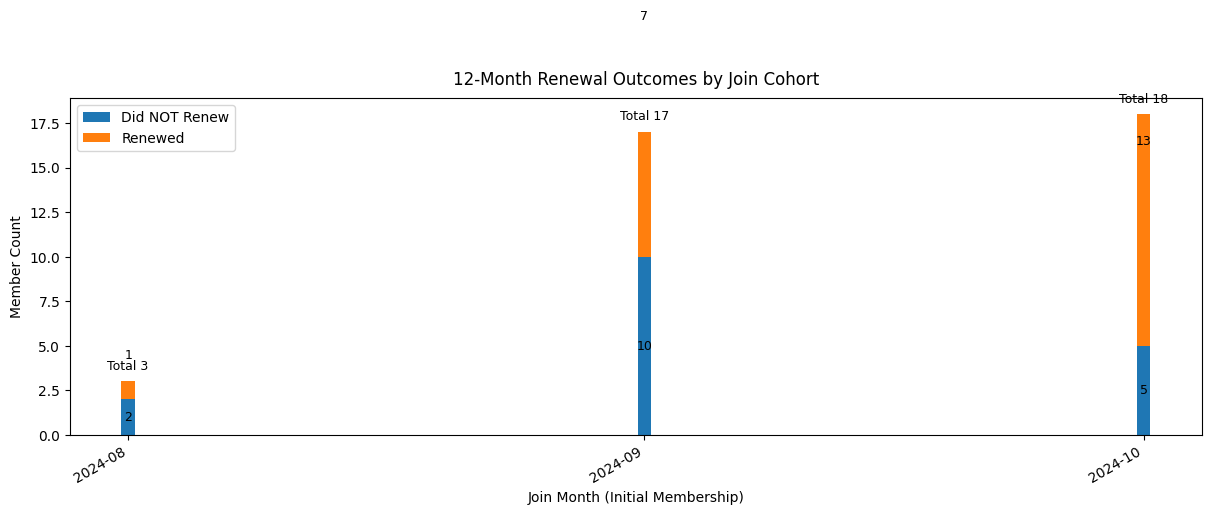

Saved: renewal_outcomes_by_cohort.png


In [32]:
import numpy as np
from matplotlib import dates as mdates

x = agg_cohort["Join_Month"]
renewed = agg_cohort["Renewed"].astype(int)
not_renewed = agg_cohort["Not_Renewed"].astype(int)
totals = agg_cohort["Eligible"].astype(int)

fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)

bars1 = ax.bar(x, not_renewed, label="Did NOT Renew")
bars2 = ax.bar(x, renewed, bottom=not_renewed, label="Renewed")

ax.set_title("12-Month Renewal Outcomes by Join Cohort", pad=10)
ax.set_xlabel("Join Month (Initial Membership)")
ax.set_ylabel("Member Count")
ax.legend()

# Date tick control (monthly ticks, nicer format)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=30, ha="right")

# Annotate segment counts
for b in bars1:
    h = b.get_height()
    if h > 0:
        ax.text(b.get_x() + b.get_width()/2, b.get_y() + h/2, f"{int(h)}",
                ha="center", va="center", fontsize=9)
for b in bars2:
    h = b.get_height()
    if h > 0:
        ax.text(b.get_x() + b.get_width()/2, b.get_y() + h/2 + not_renewed.iloc[list(bars2).index(b)],
                f"{int(h)}", ha="center", va="center", fontsize=9)

# Annotate totals on top
tops = (not_renewed + renewed).to_numpy()
for i, (xpos, top, tot) in enumerate(zip(x, tops, totals)):
    ax.text(xpos, top + 0.5, f"Total {int(tot)}", ha="center", va="bottom", fontsize=9)

plt.show()
fig.savefig("renewal_outcomes_by_cohort.png", dpi=200, bbox_inches="tight")
print("Saved: renewal_outcomes_by_cohort.png")


In [34]:
# Build outcomes by membership level (who could have renewed vs did renew)
eligible_levels = eligible[["Account ID", "Membership Level", "Renewed_12m"]].copy()

level_outcomes = (
    eligible_levels.groupby("Membership Level")
    .agg(Eligible=("Account ID", "count"),
         Renewed=("Renewed_12m", "sum"))
    .reset_index()
)
level_outcomes["Not_Renewed"] = level_outcomes["Eligible"] - level_outcomes["Renewed"]
level_outcomes.sort_values("Eligible", ascending=False, inplace=True)

display(level_outcomes)


,Membership Level,Eligible,Renewed,Not_Renewed
0,Freedom Membership,19,11,8
1,Liberty Membership,11,3,8
2,Patriot Level Membership,5,5,0
3,President’s Council Membership,3,2,1


level_outcomes shape: (4, 4)


,Membership Level,Eligible,Renewed,Not_Renewed
0,Freedom Membership,19,11,8
1,Liberty Membership,11,3,8
2,Patriot Level Membership,5,5,0
3,President’s Council Membership,3,2,1


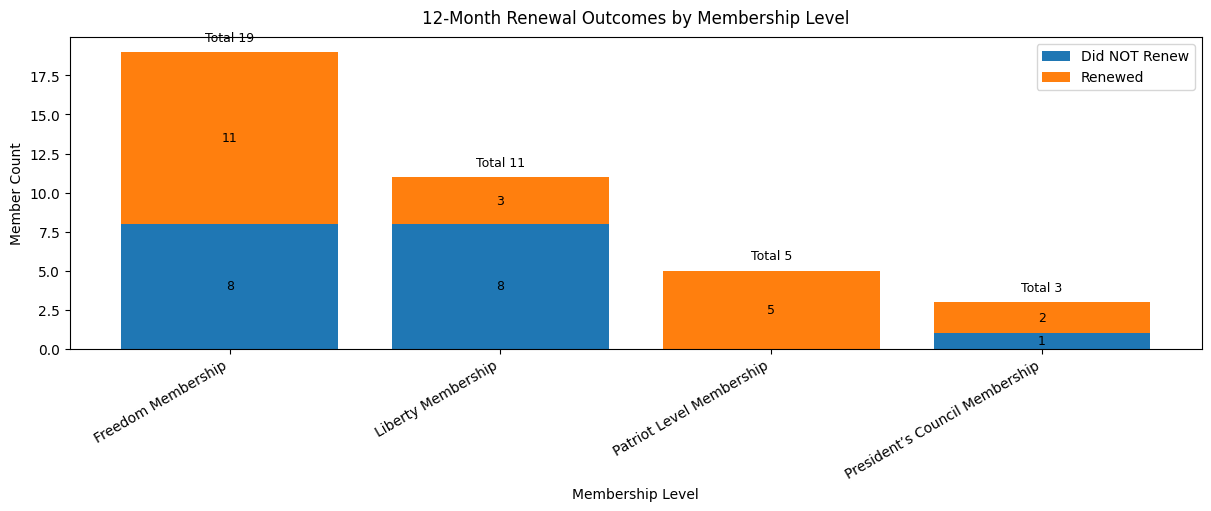

Saved: renewal_outcomes_by_level.png


In [35]:
print("level_outcomes shape:", level_outcomes.shape)
display(level_outcomes)

if level_outcomes.empty:
    raise ValueError("level_outcomes is empty—no eligible members by level (check eligibility window/rules).")

levels = level_outcomes["Membership Level"].astype(str).tolist()
renewed_lvl = level_outcomes["Renewed"].astype(int).to_numpy()
not_renewed_lvl = level_outcomes["Not_Renewed"].astype(int).to_numpy()
totals_lvl = level_outcomes["Eligible"].astype(int).to_numpy()

fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)

xpos = np.arange(len(levels))
b1 = ax.bar(xpos, not_renewed_lvl, label="Did NOT Renew")
b2 = ax.bar(xpos, renewed_lvl, bottom=not_renewed_lvl, label="Renewed")

ax.set_title("12-Month Renewal Outcomes by Membership Level", pad=10)
ax.set_xlabel("Membership Level")
ax.set_ylabel("Member Count")
ax.set_xticks(xpos, levels, rotation=30, ha="right")
ax.legend()

# Annotate segments
for i, (nr, r) in enumerate(zip(not_renewed_lvl, renewed_lvl)):
    if nr > 0:
        ax.text(i, nr/2, f"{int(nr)}", ha="center", va="center", fontsize=9)
    if r > 0:
        ax.text(i, nr + r/2, f"{int(r)}", ha="center", va="center", fontsize=9)
    ax.text(i, nr + r + 0.5, f"Total {int(totals_lvl[i])}", ha="center", va="bottom", fontsize=9)

plt.show()
fig.savefig("renewal_outcomes_by_level.png", dpi=200, bbox_inches="tight")
print("Saved: renewal_outcomes_by_level.png")


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Inline plotting
%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 5)

# If df not present, load from your CSV
if 'df' not in globals():
    df = pd.read_csv("data/membership.allmembers.csv", dtype=str)
    df["Created On"] = pd.to_datetime(df["Created On"], errors="coerce")
    df = df.dropna(subset=["Created On"]).copy()
    df["Account ID"] = df["Account ID"].astype(str).str.strip()
    df["Membership Level"] = df["Membership Level"].astype(str).str.strip()
    df["Term"] = df["Term"].astype(str)
    df["_is_renewal"] = df["Term"].str.contains("(Renew)", case=False, regex=False)

# First-time (initial) row per account: prefer earliest non-renewal; else earliest overall
nonrenew_rows = df[~df["_is_renewal"]]
if not nonrenew_rows.empty:
    first_initial = (nonrenew_rows.sort_values(["Account ID", "Created On"])
                                  .groupby("Account ID", as_index=False)
                                  .first())
else:
    first_initial = (df.sort_values(["Account ID", "Created On"])
                       .groupby("Account ID", as_index=False)
                       .first())

first_initial["Join_Month"] = first_initial["Created On"].dt.to_period("M").dt.to_timestamp()

# Renewal rows + first renewal per account (if any)
renewals = df[df["_is_renewal"]].copy()
first_renewal = (renewals.sort_values(["Account ID", "Created On"])
                           .groupby("Account ID", as_index=False)
                           .first()[["Account ID", "Created On"]]
                           .rename(columns={"Created On": "First_Renewal_Date"}))

cohort = first_initial.merge(first_renewal, on="Account ID", how="left")

def months_between(later_ts, earlier_ts):
    if pd.isna(later_ts) or pd.isna(earlier_ts):
        return np.nan
    return (later_ts.to_period("M") - earlier_ts.to_period("M")).n

# empirical months-to-renewal for accounts that actually renewed
cohort["Months_To_Renewal"] = cohort.apply(
    lambda r: months_between(r["First_Renewal_Date"], r["Created On"]), axis=1
)


In [37]:
# Keep sane lag window; tweak if your program is not annual
LAG_MIN, LAG_MAX = 6, 18

lags = cohort.loc[
    cohort["Months_To_Renewal"].between(LAG_MIN, LAG_MAX, inclusive="both"),
    "Months_To_Renewal"
].dropna().astype(int)

if lags.empty:
    raise ValueError("No observed renewals in the window to learn timing from. Consider widening LAG_MIN/LAG_MAX.")

pmf = (lags.value_counts().sort_index() / len(lags)).rename("prob").to_frame()
pmf.index.name = "lag_months"
display(pmf)

# For conditional forecasting, we'll need quick lookups:
pmf_dict = pmf["prob"].to_dict()
cum_tail = {}  # survival > e
sorted_lags = sorted(pmf_dict.keys())
for e in range(0, max(sorted_lags)+1):
    tail = sum(p for k, p in pmf_dict.items() if k > e)
    cum_tail[e] = tail


,prob
lag_months,
8,0.045455
12,0.954545


In [38]:
# Horizon: forecast next 12 months from dataset "today" (max Created On in df)
today = df["Created On"].max().to_period("M").to_timestamp()
horizon_months = 12
future_months = pd.period_range(
    (today + pd.offsets.MonthBegin(1)).to_period("M"),  # next month
    periods=horizon_months, freq="M"
).to_timestamp()

# Members who have NOT yet renewed as of "today"
pending = cohort[pd.isna(cohort["First_Renewal_Date"]) | (cohort["First_Renewal_Date"] > today)].copy()

# For each pending member, distribute expected renewal probability across FUTURE months
rows = []
for _, r in pending.iterrows():
    join_month = r["Created On"].to_period("M").to_timestamp()
    level = r["Membership Level"]
    # elapsed months since join as of "today"
    elapsed = months_between(today, r["Created On"])
    # If elapsed is nan or negative (shouldn't happen), skip
    if pd.isna(elapsed) or elapsed < 0:
        continue
    elapsed = int(elapsed)

    # Remaining probability mass (has not renewed by 'elapsed')
    tail = cum_tail.get(elapsed, 0.0)
    if tail <= 0:
        continue  # according to PMF, almost everyone who renews has done so by 'elapsed'

    # For each future month m, compute lag k and conditional probability
    for m in future_months:
        k = months_between(m, r["Created On"])
        if k is None or pd.isna(k):
            continue
        k = int(k)
        if k <= elapsed:
            continue  # already in the past relative to 'today'
        if k in pmf_dict:
            p_uncond = pmf_dict[k]
            p_cond = p_uncond / tail  # conditional on surviving past 'elapsed'
            rows.append({"Forecast_Month": m, "Expected_Renewal": p_cond, "Membership Level": level})

forecast_df = pd.DataFrame(rows)
if forecast_df.empty:
    raise ValueError("Forecast produced no rows. Likely no pending members or PMF tail mass beyond elapsed months.")

# Aggregate to get expected renewals per future month
forecast_monthly = (forecast_df
                    .groupby("Forecast_Month")["Expected_Renewal"]
                    .sum()
                    .rename("Expected_Renewals")
                    .reset_index()
                    .sort_values("Forecast_Month"))

# And by level per month
forecast_by_level = (forecast_df
                     .groupby(["Forecast_Month","Membership Level"])["Expected_Renewal"]
                     .sum()
                     .rename("Expected_Renewals")
                     .reset_index()
                     .sort_values(["Forecast_Month","Membership Level"]))

display(forecast_monthly.head(12))


,Forecast_Month,Expected_Renewals
0,2025-11-01,12.545455
1,2025-12-01,13.227273
2,2026-01-01,23.318182
3,2026-02-01,7.136364
4,2026-03-01,11.590909
5,2026-04-01,4.909091
6,2026-05-01,7.045455
7,2026-06-01,2.954545
8,2026-07-01,2.863636
9,2026-08-01,2.863636


In [39]:
# Horizon: forecast next 12 months from dataset "today" (max Created On in df)
today = df["Created On"].max().to_period("M").to_timestamp()
horizon_months = 12
future_months = pd.period_range(
    (today + pd.offsets.MonthBegin(1)).to_period("M"),  # next month
    periods=horizon_months, freq="M"
).to_timestamp()

# Members who have NOT yet renewed as of "today"
pending = cohort[pd.isna(cohort["First_Renewal_Date"]) | (cohort["First_Renewal_Date"] > today)].copy()

# For each pending member, distribute expected renewal probability across FUTURE months
rows = []
for _, r in pending.iterrows():
    join_month = r["Created On"].to_period("M").to_timestamp()
    level = r["Membership Level"]
    # elapsed months since join as of "today"
    elapsed = months_between(today, r["Created On"])
    # If elapsed is nan or negative (shouldn't happen), skip
    if pd.isna(elapsed) or elapsed < 0:
        continue
    elapsed = int(elapsed)

    # Remaining probability mass (has not renewed by 'elapsed')
    tail = cum_tail.get(elapsed, 0.0)
    if tail <= 0:
        continue  # according to PMF, almost everyone who renews has done so by 'elapsed'

    # For each future month m, compute lag k and conditional probability
    for m in future_months:
        k = months_between(m, r["Created On"])
        if k is None or pd.isna(k):
            continue
        k = int(k)
        if k <= elapsed:
            continue  # already in the past relative to 'today'
        if k in pmf_dict:
            p_uncond = pmf_dict[k]
            p_cond = p_uncond / tail  # conditional on surviving past 'elapsed'
            rows.append({"Forecast_Month": m, "Expected_Renewal": p_cond, "Membership Level": level})

forecast_df = pd.DataFrame(rows)
if forecast_df.empty:
    raise ValueError("Forecast produced no rows. Likely no pending members or PMF tail mass beyond elapsed months.")

# Aggregate to get expected renewals per future month
forecast_monthly = (forecast_df
                    .groupby("Forecast_Month")["Expected_Renewal"]
                    .sum()
                    .rename("Expected_Renewals")
                    .reset_index()
                    .sort_values("Forecast_Month"))

# And by level per month
forecast_by_level = (forecast_df
                     .groupby(["Forecast_Month","Membership Level"])["Expected_Renewal"]
                     .sum()
                     .rename("Expected_Renewals")
                     .reset_index()
                     .sort_values(["Forecast_Month","Membership Level"]))

display(forecast_monthly.head(12))


,Forecast_Month,Expected_Renewals
0,2025-11-01,12.545455
1,2025-12-01,13.227273
2,2026-01-01,23.318182
3,2026-02-01,7.136364
4,2026-03-01,11.590909
5,2026-04-01,4.909091
6,2026-05-01,7.045455
7,2026-06-01,2.954545
8,2026-07-01,2.863636
9,2026-08-01,2.863636


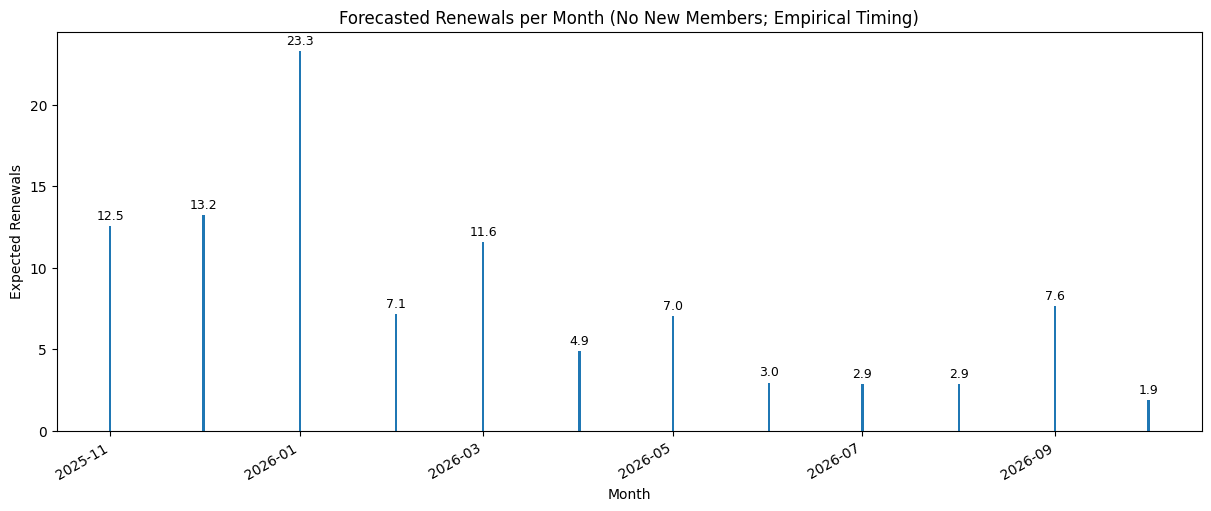

In [40]:
fig, ax = plt.subplots(figsize=(12,5), constrained_layout=True)
bars = ax.bar(forecast_monthly["Forecast_Month"], forecast_monthly["Expected_Renewals"])

ax.set_title("Forecasted Renewals per Month (No New Members; Empirical Timing)")
ax.set_xlabel("Month")
ax.set_ylabel("Expected Renewals")

# Label bars with counts (rounded)
for b in bars:
    val = b.get_height()
    if val > 0:
        ax.text(b.get_x()+b.get_width()/2, val + max(0.02, 0.01*forecast_monthly["Expected_Renewals"].max()),
                f"{val:.1f}", ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=30, ha="right")
plt.show()


Expected renewals in January 2026 (no new members): ~23.3


,Forecast_Month,Membership Level,Expected_Renewals
8,2026-01-01,Freedom Membership,14.318182
9,2026-01-01,Liberty Membership,6.000000
10,2026-01-01,Patriot Level Membership,2.000000
11,2026-01-01,President’s Council Membership,1.000000


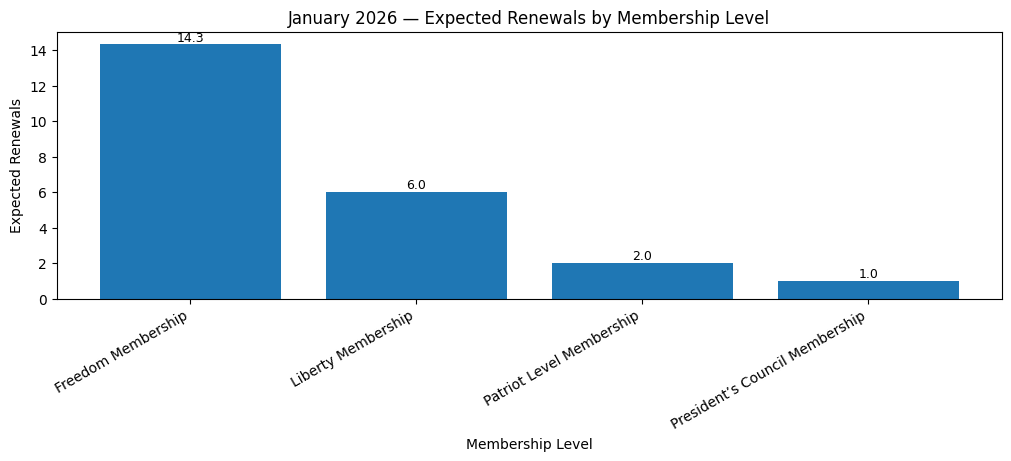

In [41]:
# Pick January 2026
jan_2026 = pd.Timestamp("2026-01-01").to_period("M").to_timestamp()

# Overall expected renewals in Jan 2026
jan_total = forecast_monthly.loc[
    forecast_monthly["Forecast_Month"] == jan_2026, "Expected_Renewals"
].sum()

# By membership level in Jan 2026
jan_by_level = (forecast_by_level[forecast_by_level["Forecast_Month"] == jan_2026]
                .sort_values("Expected_Renewals", ascending=False))

print(f"Expected renewals in January 2026 (no new members): ~{jan_total:.1f}")
display(jan_by_level)

# Optional: bar chart by level for Jan 2026
if not jan_by_level.empty:
    fig, ax = plt.subplots(figsize=(10,4.5), constrained_layout=True)
    bars = ax.bar(jan_by_level["Membership Level"].astype(str),
                  jan_by_level["Expected_Renewals"])
    ax.set_title("January 2026 — Expected Renewals by Membership Level")
    ax.set_xlabel("Membership Level"); ax.set_ylabel("Expected Renewals")
    for b in bars:
        v = b.get_height()
        if v > 0:
            ax.text(b.get_x()+b.get_width()/2, v + 0.02, f"{v:.1f}", ha="center", va="bottom", fontsize=9)
    plt.xticks(rotation=30, ha="right")
    plt.show()
else:
    print("No forecast mass landed in Jan 2026 (check PMF/window or pending members).")


In [42]:
# Members who joined in January 2025
jan_2025 = pd.Timestamp("2025-01-01").to_period("M").to_timestamp()
cohort_jan25 = cohort[cohort["Join_Month"] == jan_2025].copy()

# Still pending as of 'today'
pending_jan25 = cohort_jan25[pd.isna(cohort_jan25["First_Renewal_Date"]) | (cohort_jan25["First_Renewal_Date"] > today)].copy()

# Expected renewals for that cohort in January 2026
target_month = pd.Timestamp("2026-01-01").to_period("M").to_timestamp()
exp_from_jan25 = 0.0
rows_detail = []
for _, r in pending_jan25.iterrows():
    elapsed = months_between(today, r["Created On"])
    if pd.isna(elapsed) or elapsed < 0: 
        continue
    elapsed = int(elapsed)
    k = months_between(target_month, r["Created On"])
    if k is None or pd.isna(k) or k <= elapsed:
        continue
    tail = cum_tail.get(elapsed, 0.0)
    if tail <= 0:
        continue
    if k in pmf_dict:
        p_cond = pmf_dict[k] / tail
        exp_from_jan25 += p_cond
        rows_detail.append({"Account ID": r["Account ID"], "Expected_In_Jan2026": p_cond, "Level": r["Membership Level"]})

print(f"Expected renewals in Jan 2026 FROM Jan 2025 cohort (pending only): ~{exp_from_jan25:.1f}")

# Breakdown by level within that cohort
if rows_detail:
    det = pd.DataFrame(rows_detail)
    det_by_level = det.groupby("Level")["Expected_In_Jan2026"].sum().reset_index().sort_values("Expected_In_Jan2026", ascending=False)
    display(det_by_level)


Expected renewals in Jan 2026 FROM Jan 2025 cohort (pending only): ~23.0


,Level,Expected_In_Jan2026
0,Freedom Membership,14.0
1,Liberty Membership,6.0
2,Patriot Level Membership,2.0
3,President’s Council Membership,1.0


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 5)

CSV_PATH = Path("../data/membership/allmembers.csv")
assert CSV_PATH.exists(), f"File not found: {CSV_PATH}"

df = pd.read_csv(CSV_PATH, dtype=str)

# Normalize core columns
df["Account ID"] = df["Account ID"].astype(str).str.strip()
df["Membership Level"] = df["Membership Level"].astype(str).str.strip()
df["Status"] = df["Status"].astype(str).str.strip().str.title()
df["Term"] = df["Term"].astype(str)
df["Created On"] = pd.to_datetime(df["Created On"], errors="coerce")
df = df.dropna(subset=["Created On"]).copy()

# Renewal flag from Term
df["_is_renewal"] = df["Term"].str.contains("(Renew)", case=False, regex=False)

# Try to detect an Auto-Renew column if present (optional)
auto_cols = [c for c in df.columns if "auto" in c.lower() and "renew" in c.lower()]
AUTO_COL = auto_cols[0] if auto_cols else None
if AUTO_COL:
    df[AUTO_COL] = df[AUTO_COL].astype(str).str.strip().str.lower()
    truthy = {"true","yes","y","1","auto","auto-renew","autorenew"}
    df["_auto_bucket"] = np.where(df[AUTO_COL].isin(truthy), "Auto-Renew", "Manual")
else:
    df["_auto_bucket"] = "Not Tracked"  # fallback bucket if no column exists


In [44]:
# Build first-time (initial) row per account — prefer earliest non-renewal row; otherwise earliest overall
nonrenew_rows = df[~df["_is_renewal"]]
if not nonrenew_rows.empty:
    first_initial = (nonrenew_rows.sort_values(["Account ID","Created On"])
                                  .groupby("Account ID", as_index=False)
                                  .first())
else:
    first_initial = (df.sort_values(["Account ID","Created On"])
                       .groupby("Account ID", as_index=False)
                       .first())

first_initial["Join_Month"] = first_initial["Created On"].dt.to_period("M").dt.to_timestamp()

# First renewal per account (if any)
renewals = df[df["_is_renewal"]].copy()
first_renewal = (renewals.sort_values(["Account ID","Created On"])
                           .groupby("Account ID", as_index=False)
                           .first()[["Account ID","Created On"]]
                           .rename(columns={"Created On":"First_Renewal_Date"}))

cohort = first_initial.merge(first_renewal, on="Account ID", how="left")

def months_between(later_ts, earlier_ts):
    if pd.isna(later_ts) or pd.isna(earlier_ts):
        return np.nan
    return (later_ts.to_period("M") - earlier_ts.to_period("M")).n


In [45]:
# Months-to-renewal from observed renewals
cohort["Months_To_Renewal"] = cohort.apply(
    lambda r: months_between(r["First_Renewal_Date"], r["Created On"]), axis=1
)

# Use a sane timing window (adjust if needed)
LAG_MIN, LAG_MAX = 6, 18
lags = (cohort.loc[
            cohort["Months_To_Renewal"].between(LAG_MIN, LAG_MAX, inclusive="both"),
            "Months_To_Renewal"
        ].dropna().astype(int))

if lags.empty:
    raise ValueError("No observed renewals in 6–18 month window to learn timing from. Widen the window or check data.")

pmf = (lags.value_counts().sort_index() / len(lags)).rename("prob").to_frame()
pmf.index.name = "lag_months"

# Survival tail mass for conditional probabilities
pmf_dict = pmf["prob"].to_dict()
sorted_lags = sorted(pmf_dict.keys())
cum_tail = {e: sum(p for k,p in pmf_dict.items() if k > e) for e in range(0, (max(sorted_lags) if sorted_lags else 0)+1)}

# Forecast next 6 months starting next month after dataset "today"
today = df["Created On"].max().to_period("M").to_timestamp()
months_ahead = 6
future_months = pd.period_range((today + pd.offsets.MonthBegin(1)).to_period("M"),
                                periods=months_ahead, freq="M").to_timestamp()


_type,Freedom Membership,Liberty Membership,Patriot Level Membership,President’s Council Membership
Month,,,,
2025-11-01 00:00:00,6,3,2,1
2025-12-01 00:00:00,7,2,3,1
2026-01-01 00:00:00,14,6,2,1
2026-02-01 00:00:00,3,2,1,1
2026-03-01 00:00:00,6,4,2,0
2026-04-01 00:00:00,3,1,1,0


_type,Freedom Membership,Liberty Membership,Patriot Level Membership,President’s Council Membership
Month,,,,
2025-11-01 00:00:00,6.3,3.2,2.1,1.0
2025-12-01 00:00:00,7.1,2.0,3.0,1.0
2026-01-01 00:00:00,14.3,6.0,2.0,1.0
2026-02-01 00:00:00,3.1,2.0,1.0,1.0
2026-03-01 00:00:00,5.9,3.8,1.9,0.0
2026-04-01 00:00:00,3.0,1.0,1.0,0.0


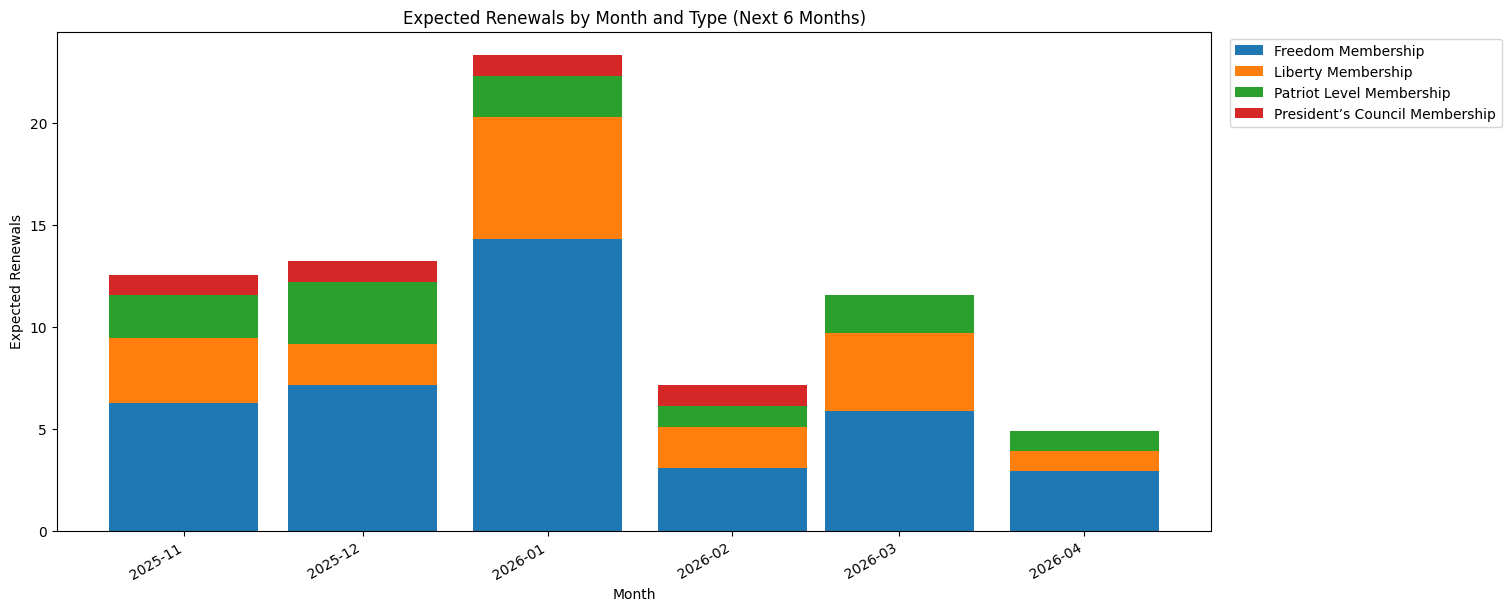

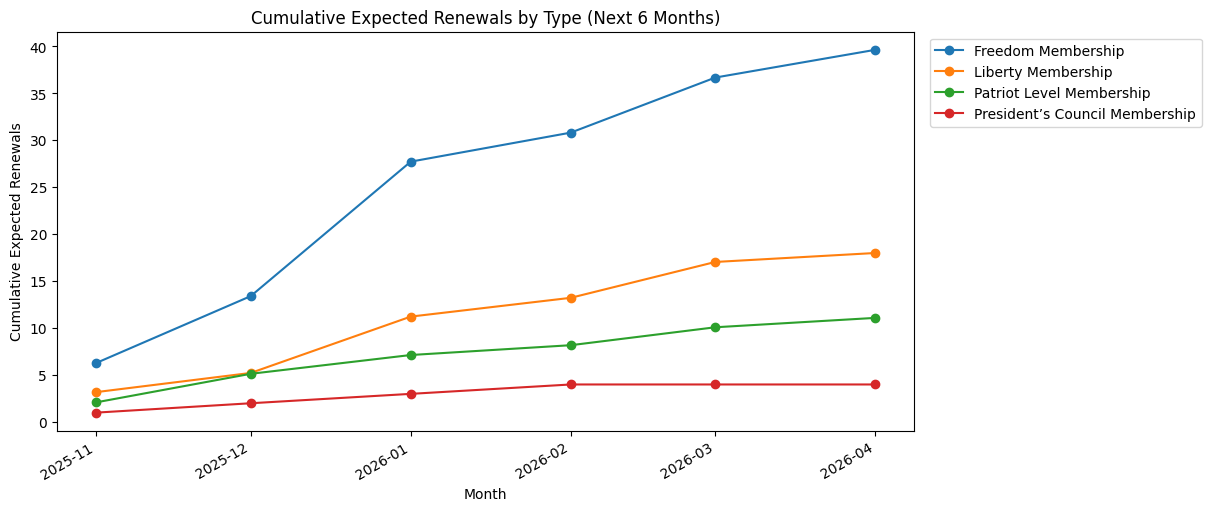

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) Ensure pending already includes the initial-level fields ---
# If `_auto_bucket` is missing on `pending`, try to pull it from first_initial once (with a suffix).
if "_auto_bucket" not in pending.columns:
    fi_auto = first_initial[["Account ID", "_auto_bucket"]].rename(columns={"_auto_bucket":"_auto_bucket_init"})
    pending = pending.merge(fi_auto, on="Account ID", how="left")
    pending["_auto_bucket"] = pending.get("_auto_bucket", pending.get("_auto_bucket_init"))
    pending.drop(columns=[c for c in ["_auto_bucket_init"] if c in pending.columns], inplace=True)

# Safety default if still missing
if "_auto_bucket" not in pending.columns:
    pending["_auto_bucket"] = "Not Tracked"

# --- 1) Build renewal TYPE (no merge needed) ---
if AUTO_COL:
    pending["_type"] = pending["Membership Level"].astype(str) + " — " + pending["_auto_bucket"].astype(str)
else:
    pending["_type"] = pending["Membership Level"].astype(str)

# --- 2) Recompute Due_to_Renew (eligibility month rule) ---
ELIGIBLE_OFFSET = 12  # months
pending["Eligibility_Month"] = (pending["Created On"] + pd.DateOffset(months=ELIGIBLE_OFFSET)).dt.to_period("M").dt.to_timestamp()

due_rows = (pending[pending["Eligibility_Month"].isin(future_months)]
            .groupby(["Eligibility_Month","_type"])
            .size()
            .rename("Due_to_Renew")
            .reset_index()
            .rename(columns={"Eligibility_Month":"Month"}))

# --- 3) Recompute Expected_Renewals using conditional PMF ---
def months_between(later_ts, earlier_ts):
    if pd.isna(later_ts) or pd.isna(earlier_ts):
        return np.nan
    return (later_ts.to_period("M") - earlier_ts.to_period("M")).n

rows = []
# Need 'today', 'pmf_dict', 'cum_tail', 'future_months' from your earlier cells
for _, r in pending.iterrows():
    elapsed = months_between(today, r["Created On"])
    if pd.isna(elapsed) or elapsed < 0:
        continue
    elapsed = int(elapsed)
    tail = cum_tail.get(elapsed, 0.0)
    if tail <= 0:
        continue
    for m in future_months:
        k = months_between(m, r["Created On"])
        if k is None or pd.isna(k) or k <= elapsed:
            continue
        if k in pmf_dict:
            p_cond = pmf_dict[k] / tail
            rows.append({"Month": m, "_type": r["_type"], "Expected_Renewals": p_cond})

expected_df = pd.DataFrame(rows)
expected_by_type = (expected_df.groupby(["Month","_type"])["Expected_Renewals"]
                    .sum().reset_index())

# --- 4) Combine summary for the next 6 months ---
summary_next6 = (pd.merge(due_rows, expected_by_type, on=["Month","_type"], how="outer")
                   .fillna({"Due_to_Renew":0, "Expected_Renewals":0})
                   .sort_values(["Month","_type"])
                   .reset_index(drop=True))

# Pivot tables for the deck
due_pivot = summary_next6.pivot(index="Month", columns="_type", values="Due_to_Renew").fillna(0).astype(int)
exp_pivot = summary_next6.pivot(index="Month", columns="_type", values="Expected_Renewals").fillna(0)

display(due_pivot.style.format("{:,.0f}").set_caption("Due to Renew (count) — Next 6 Months"))
display(exp_pivot.style.format("{:,.1f}").set_caption("Expected Renewals (probability-weighted) — Next 6 Months"))

# --- 5) Stacked bars with labels (Expected_Renewals by type) ---
# Make the bars thicker / wider
fig, ax = plt.subplots(figsize=(15,6), constrained_layout=True)
bottom = np.zeros(len(exp_pivot), dtype=float)
bars_by_type = {}

# Use a fixed width (for monthly date indexes, ~20–25 days works well)
bar_width = 25  # try 20–30 if you want thicker or thinner bars

for col in exp_pivot.columns:
    vals = exp_pivot[col].values
    bars = ax.bar(exp_pivot.index, vals, bottom=bottom, width=bar_width, label=col)
    bars_by_type[col] = bars
    bottom += vals  # accumulate for stacking

ax.set_title("Expected Renewals by Month and Type (Next 6 Months)")
ax.set_xlabel("Month")
ax.set_ylabel("Expected Renewals")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0))
plt.xticks(rotation=30, ha="right")
plt.show()

# --- 6) Cumulative expected renewals by type (line chart) ---
cum_by_type = exp_pivot.cumsum()

fig, ax = plt.subplots(figsize=(12,5), constrained_layout=True)
for col in cum_by_type.columns:
    ax.plot(cum_by_type.index, cum_by_type[col], marker="o", label=col)

ax.set_title("Cumulative Expected Renewals by Type (Next 6 Months)")
ax.set_xlabel("Month"); ax.set_ylabel("Cumulative Expected Renewals")
plt.xticks(rotation=30, ha="right")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0))
plt.show()


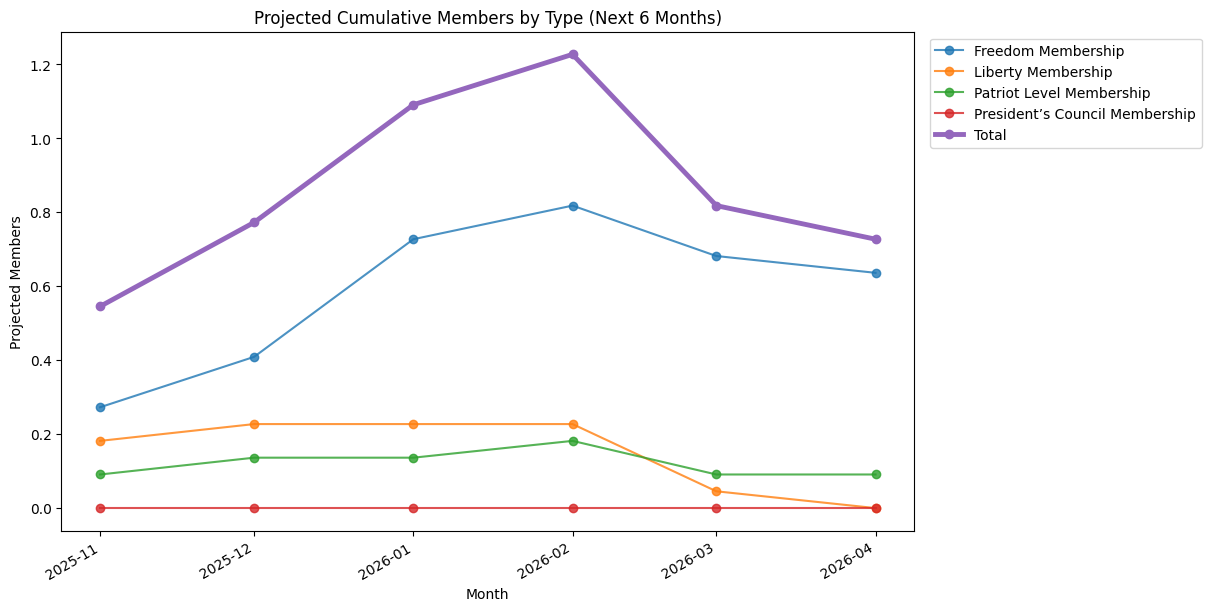

In [50]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)

# Plot each type
for col in cum_members.columns:
    ax.plot(cum_members.index, cum_members[col], marker="o", alpha=0.8, label=col)

# Plot total across types as a bold line
ax.plot(cum_total.index, cum_total.values, marker="o", linewidth=3.5, label="Total", zorder=10)

ax.set_title("Projected Cumulative Members by Type (Next 6 Months)")
ax.set_xlabel("Month"); ax.set_ylabel("Projected Members")
plt.xticks(rotation=30, ha="right")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0))
plt.show()


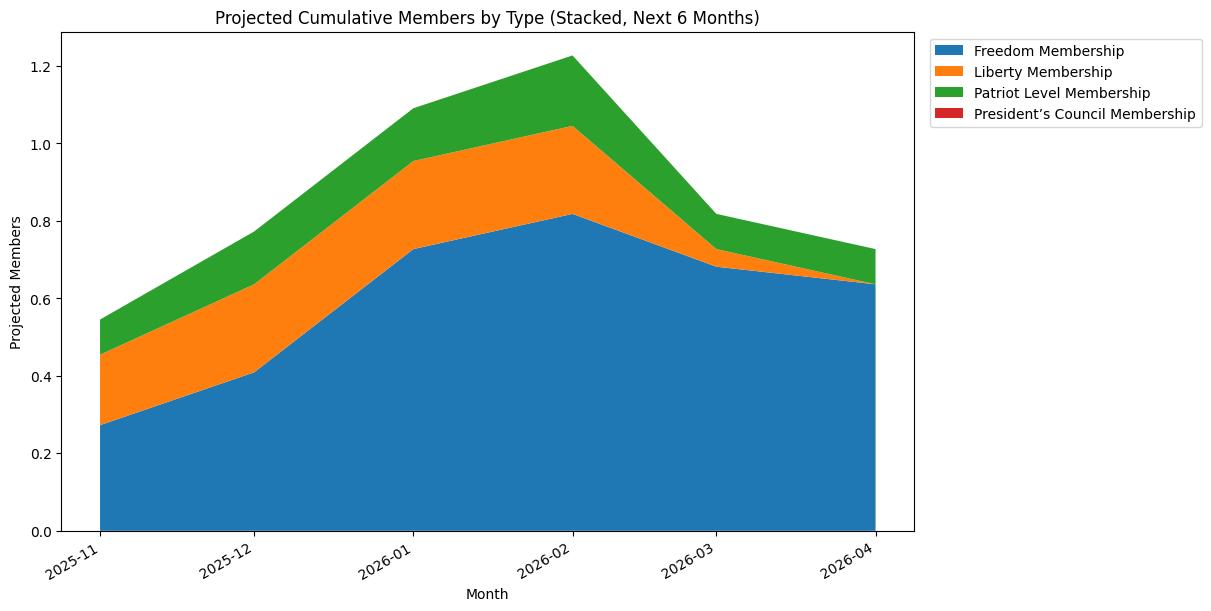

In [51]:
fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
ax.stackplot(cum_members.index, cum_members.T.values, labels=cum_members.columns)
ax.set_title("Projected Cumulative Members RENEWALS*** by Type (Stacked, Next 6 Months)")
ax.set_xlabel("Month"); ax.set_ylabel("Projected Members")
plt.xticks(rotation=30, ha="right")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0))
plt.show()


In [57]:
# === ONE-CELL REBUILD: expected renewals (next 6 months) by type ===

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 5)

# ---- Load CSV (your confirmed path) ----
CSV_PATH = Path("../data/membership/allmembers.csv")
df = pd.read_csv(CSV_PATH, dtype=str)
df.columns = df.columns.str.strip()

# ---- Robust column aliases ----
def find_exact(name):
    matches = [c for c in df.columns if c.lower().strip() == name.lower().strip()]
    if not matches:
        raise KeyError(f"Required column not found: {name}")
    return matches[0]

COL_ID   = find_exact("Account ID")
COL_DT   = find_exact("Created On")
COL_TERM = find_exact("Term")
COL_STAT = find_exact("Status")
# Membership Level may be exact or vary; try exact first, then fuzzy
lvl_exact = [c for c in df.columns if c.lower().strip() == "membership level"]
if lvl_exact:
    COL_LVL = lvl_exact[0]
else:
    lvl_fuzzy = [c for c in df.columns if "membership" in c.lower() and "level" in c.lower()]
    if not lvl_fuzzy:
        raise KeyError("Could not find a 'Membership Level' column (exact or fuzzy).")
    COL_LVL = lvl_fuzzy[0]

# ---- Normalize key columns ----
df[COL_DT]   = pd.to_datetime(df[COL_DT], errors="coerce")
df = df.dropna(subset=[COL_DT]).copy()
df[COL_ID]   = df[COL_ID].astype(str).str.strip()
df[COL_LVL]  = df[COL_LVL].astype(str).str.strip()
df[COL_TERM] = df[COL_TERM].astype(str)
df[COL_STAT] = df[COL_STAT].astype(str).str.strip()

# ---- Renewal detection strictly from Term ----
df["_is_renewal"] = df[COL_TERM].str.contains("(Renew)", case=False, regex=False)

# ---- Optional auto-renew bucket (if any column contains 'auto' & 'renew') ----
auto_cols = [c for c in df.columns if ("auto" in c.lower() and "renew" in c.lower())]
AUTO_COL = auto_cols[0] if auto_cols else None
if AUTO_COL:
    truthy = {"true","yes","y","1","auto","auto-renew","autorenew"}
    df["_auto_bucket"] = np.where(df[AUTO_COL].astype(str).str.strip().str.lower().isin(truthy),
                                  "Auto-Renew", "Manual")
else:
    df["_auto_bucket"] = "Not Tracked"

# ---- First-time (initial) row per account (prefer earliest non-renewal; else earliest overall) ----
nonrenew = df[~df["_is_renewal"]]
if not nonrenew.empty:
    first_initial = (nonrenew.sort_values([COL_ID, COL_DT])
                            .groupby(COL_ID, as_index=False).first())
else:
    first_initial = (df.sort_values([COL_ID, COL_DT])
                       .groupby(COL_ID, as_index=False).first())

# ensure _auto_bucket exists on first_initial
if "_auto_bucket" not in first_initial.columns:
    first_initial = first_initial.merge(
        df[[COL_ID, "_auto_bucket"]].drop_duplicates(COL_ID, keep="first"),
        on=COL_ID, how="left"
    )
    first_initial["_auto_bucket"].fillna("Not Tracked", inplace=True)

# ---- First renewal (if any) ----
renewals = df[df["_is_renewal"]].copy()
first_renewal = (renewals.sort_values([COL_ID, COL_DT])
                           .groupby(COL_ID, as_index=False)
                           .first()[[COL_ID, COL_DT]]
                           .rename(columns={COL_DT: "First_Renewal_Date"}))

# ---- Cohort (initial + first renewal) ----
cohort = first_initial.merge(first_renewal, on=COL_ID, how="left")

# ---- Helpers ----
def months_between(later_ts, earlier_ts):
    if pd.isna(later_ts) or pd.isna(earlier_ts): 
        return np.nan
    return (pd.to_datetime(later_ts).to_period("M") - pd.to_datetime(earlier_ts).to_period("M")).n

# ---- Empirical timing PMF (months to first renewal) ----
cohort["Months_To_Renewal"] = cohort.apply(
    lambda r: months_between(r["First_Renewal_Date"], r[COL_DT]), axis=1
)

LAG_MIN, LAG_MAX = 6, 18
lags = (cohort.loc[
            cohort["Months_To_Renewal"].between(LAG_MIN, LAG_MAX, inclusive="both"),
            "Months_To_Renewal"
        ].dropna().astype(int))
if lags.empty:
    raise ValueError("No observed renewals in 6–18 months to learn timing. Adjust LAG_MIN/LAG_MAX if needed.")

pmf = (lags.value_counts().sort_index() / len(lags))
pmf_dict = pmf.to_dict()
sorted_lags = sorted(pmf_dict)
cum_tail = {e: sum(p for k,p in pmf_dict.items() if k > e) 
            for e in range(0, (max(sorted_lags) if sorted_lags else 0)+1)}

# ---- Forecast window (next 6 months after dataset latest month) ----
today = df[COL_DT].max().to_period("M").to_timestamp()
future_months = pd.period_range((today + pd.offsets.MonthBegin(1)).to_period("M"),
                                periods=6, freq="M").to_timestamp()

# ---- Pending accounts (no renewal yet or renewal after 'today') ----
pending = cohort[(cohort["First_Renewal_Date"].isna()) | (cohort["First_Renewal_Date"] > today)].copy()

# Ensure we have level and bucket on pending WITHOUT causing suffix KeyErrors:
# 1) find a level column in pending (handle possible suffixes from merges)
level_candidates = [COL_LVL, f"{COL_LVL}_x", f"{COL_LVL}_y"] + \
                   [c for c in pending.columns if "membership" in c.lower() and "level" in c.lower()]
LEVEL_COL_IN_PENDING = next((c for c in level_candidates if c in pending.columns), None)
if LEVEL_COL_IN_PENDING is None:
    # map from first_initial if missing
    map_lvl = dict(zip(first_initial[COL_ID], first_initial[COL_LVL]))
    pending[COL_LVL] = pending[COL_ID].map(map_lvl)
    LEVEL_COL_IN_PENDING = COL_LVL

# 2) ensure _auto_bucket on pending (map from first_initial if needed)
if "_auto_bucket" not in pending.columns:
    map_bucket = dict(zip(first_initial[COL_ID], first_initial.get("_auto_bucket", "Not Tracked")))
    pending["_auto_bucket"] = pending[COL_ID].map(map_bucket).fillna("Not Tracked")

# 3) build _type label
if AUTO_COL:
    pending["_type"] = pending[LEVEL_COL_IN_PENDING].astype(str) + " — " + pending["_auto_bucket"].astype(str)
else:
    pending["_type"] = pending[LEVEL_COL_IN_PENDING].astype(str)

# ---- Expected renewals by month/type (conditional on not renewed yet) ----
rows = []
for _, r in pending.iterrows():
    elapsed = months_between(today, r[COL_DT])
    if pd.isna(elapsed) or elapsed < 0:
        continue
    elapsed = int(elapsed)
    tail = cum_tail.get(elapsed, 0.0)
    if tail <= 0:
        continue
    for m in future_months:
        k = months_between(m, r[COL_DT])
        if pd.isna(k) or k <= elapsed:
            continue
        k = int(k)
        if k in pmf_dict:
            p_cond = pmf_dict[k] / tail
            rows.append({"Month": m, "_type": r["_type"], "Expected_Renewals": p_cond})

expected_by_type = (pd.DataFrame(rows)
                    .groupby(["Month","_type"])["Expected_Renewals"]
                    .sum().reset_index())

# ---- Who is due to renew (hits 12 months) in each future month/type ----
ELIGIBLE_OFFSET = 12
pending["Eligibility_Month"] = (pending[COL_DT] + pd.DateOffset(months=ELIGIBLE_OFFSET)
                                ).dt.to_period("M").dt.to_timestamp()
due_rows = (pending[pending["Eligibility_Month"].isin(future_months)]
            .groupby(["Eligibility_Month","_type"])
            .size().rename("Due_to_Renew").reset_index()
            .rename(columns={"Eligibility_Month":"Month"}))

# ---- Final summary + pivots ----
summary_next6 = (pd.merge(due_rows, expected_by_type, on=["Month","_type"], how="outer")
                   .fillna({"Due_to_Renew":0, "Expected_Renewals":0})
                   .sort_values(["Month","_type"])
                   .reset_index(drop=True))

exp_pivot = summary_next6.pivot(index="Month", columns="_type", values="Expected_Renewals").fillna(0.0)
due_pivot = summary_next6.pivot(index="Month", columns="_type", values="Due_to_Renew").fillna(0.0)

display(exp_pivot.style.format("{:.2f}").set_caption("Expected Renewals (Next 6 Months)"))
display(due_pivot.style.format("{:.0f}").set_caption("Due to Renew (Next 6 Months)"))

# (Optional) If you prefer whole numbers for presentation:
# exp_pivot = exp_pivot.round().astype(int)


_type,Freedom Membership,Liberty Membership,Patriot Level Membership,President’s Council Membership
Month,,,,
2025-11-01 00:00:00,6.27,3.18,2.09,1.00
2025-12-01 00:00:00,7.14,2.05,3.05,1.00
2026-01-01 00:00:00,14.32,6.00,2.00,1.00
2026-02-01 00:00:00,3.09,2.00,1.05,1.00
2026-03-01 00:00:00,5.86,3.82,1.91,0.00
2026-04-01 00:00:00,2.95,0.95,1.00,0.00


_type,Freedom Membership,Liberty Membership,Patriot Level Membership,President’s Council Membership
Month,,,,
2025-11-01 00:00:00,6,3,2,1
2025-12-01 00:00:00,7,2,3,1
2026-01-01 00:00:00,14,6,2,1
2026-02-01 00:00:00,3,2,1,1
2026-03-01 00:00:00,6,4,2,0
2026-04-01 00:00:00,3,1,1,0


,Renewal_Rate
Membership Level,
Freedom Membership,57.89%
President’s Council Membership,66.67%
Patriot Level Membership,100.00%
Liberty Membership,27.27%


,Baseline_Active_Today
Membership Level,
Freedom Membership,76
President’s Council Membership,7
Patriot Level Membership,18
Liberty Membership,24


,Month,Membership Level,Due_to_Renew,Renewal_Rate,Expected_Renewals,Projected_Ending_Total
0,2025-11-01 00:00:00,Freedom Membership,7,57.9%,4.1,73
3,2025-11-01 00:00:00,Liberty Membership,3,27.3%,0.8,22
2,2025-11-01 00:00:00,Patriot Level Membership,2,100.0%,2.0,18
1,2025-11-01 00:00:00,President’s Council Membership,1,66.7%,0.7,7
4,2025-12-01 00:00:00,Freedom Membership,7,57.9%,4.1,70
7,2025-12-01 00:00:00,Liberty Membership,2,27.3%,0.5,20
6,2025-12-01 00:00:00,Patriot Level Membership,3,100.0%,3.0,18
5,2025-12-01 00:00:00,President’s Council Membership,1,66.7%,0.7,6
8,2026-01-01 00:00:00,Freedom Membership,14,57.9%,8.1,64
11,2026-01-01 00:00:00,Liberty Membership,9,27.3%,2.5,14


,Freedom Membership,President’s Council Membership,Patriot Level Membership,Liberty Membership
2025-11-01 00:00:00,73,7,18,22
2025-12-01 00:00:00,70,6,18,20
2026-01-01 00:00:00,64,6,18,14
2026-02-01 00:00:00,63,6,18,12
2026-03-01 00:00:00,60,6,18,9
2026-04-01 00:00:00,59,6,18,9


,Projected_Total_Members
2025-11-01,120
2025-12-01,114
2026-01-01,102
2026-02-01,99
2026-03-01,93
2026-04-01,92


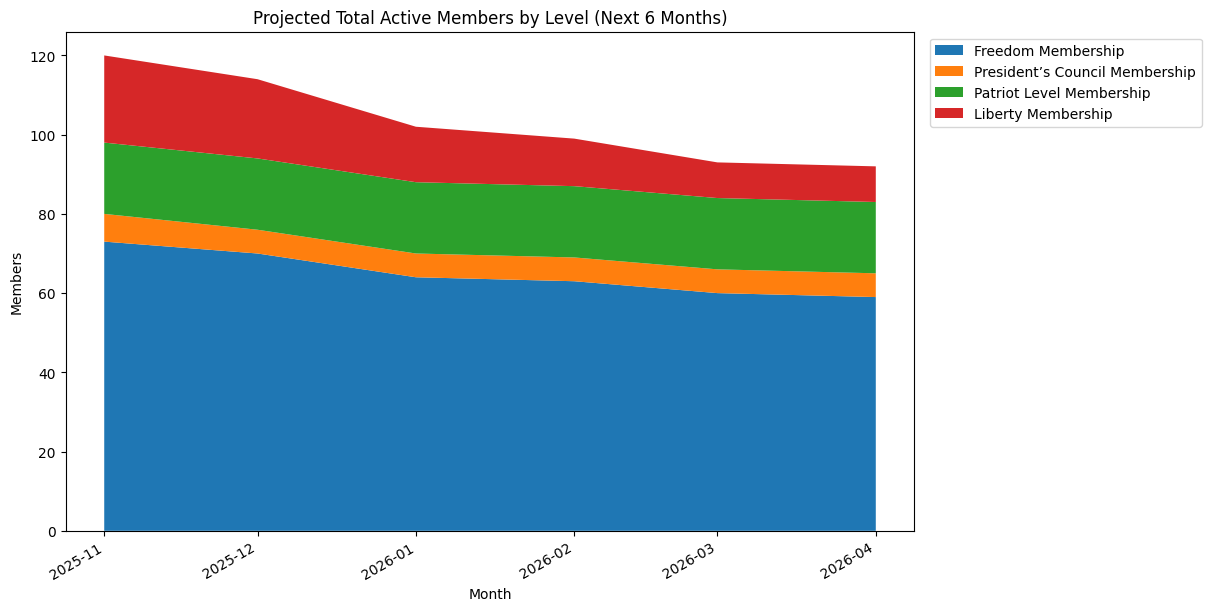

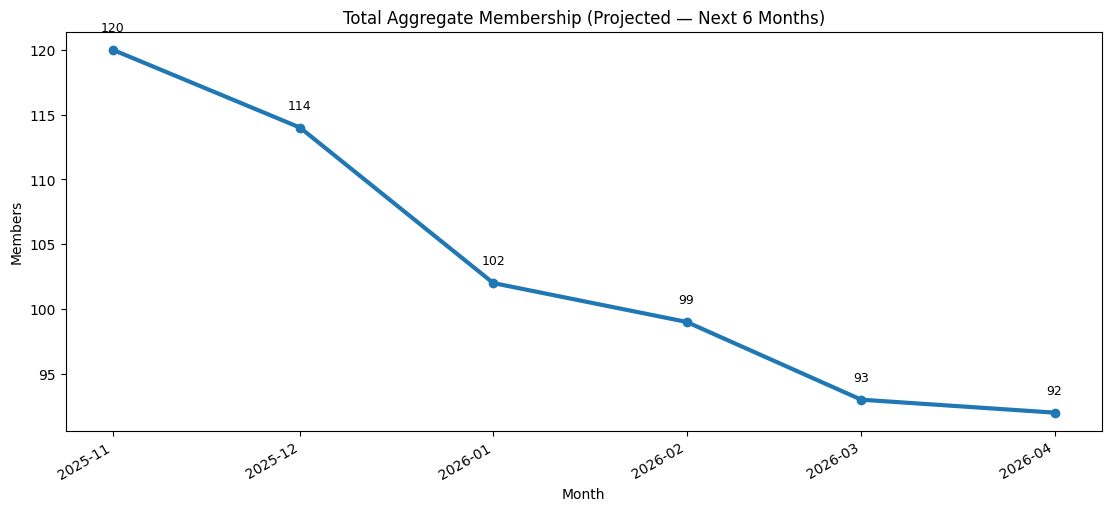

In [59]:
# ======= ONE-CELL: Project total membership (next 6 months) =======

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 5)

# ---- Load and normalize ----
CSV_PATH = Path("../data/membership/allmembers.csv")
df = pd.read_csv(CSV_PATH, dtype=str)
df.columns = df.columns.str.strip()

# Required columns (robust aliases)
COL_ID   = [c for c in df.columns if c.lower() == "account id"][0]
COL_DT   = [c for c in df.columns if c.lower() == "created on"][0]
COL_LVL  = [c for c in df.columns if "membership" in c.lower() and "level" in c.lower()][0]
COL_TERM = [c for c in df.columns if c.lower() == "term"][0]
COL_STAT = [c for c in df.columns if c.lower() == "status"][0]

# Parse dates & clean
df[COL_DT] = pd.to_datetime(df[COL_DT], errors="coerce")
df = df.dropna(subset=[COL_DT]).copy()
df[COL_ID]  = df[COL_ID].astype(str).str.strip()
df[COL_LVL] = df[COL_LVL].astype(str).str.strip()
df[COL_TERM]= df[COL_TERM].astype(str)
df[COL_STAT]= df[COL_STAT].astype(str).str.strip()

# Flags
df["_is_renewal"] = df[COL_TERM].str.contains("(Renew)", case=False, regex=False)

# Helpers
def months_between(later_ts, earlier_ts):
    if pd.isna(later_ts) or pd.isna(earlier_ts): return np.nan
    return (pd.to_datetime(later_ts).to_period("M") - pd.to_datetime(earlier_ts).to_period("M")).n

today = df[COL_DT].max().to_period("M").to_timestamp()

# ========= 1) Historical renewal rate by level =========
# Define initial join per account (prefer earliest non-renewal; else earliest)
nonrenew = df[~df["_is_renewal"]]
if not nonrenew.empty:
    first_initial = (nonrenew.sort_values([COL_ID, COL_DT])
                            .groupby(COL_ID, as_index=False).first())
else:
    first_initial = (df.sort_values([COL_ID, COL_DT])
                       .groupby(COL_ID, as_index=False).first())

# First renewal per account (if any) and months to renewal
renewals = df[df["_is_renewal"]].copy()
first_renewal = (renewals.sort_values([COL_ID, COL_DT])
                           .groupby(COL_ID, as_index=False)
                           .first()[[COL_ID, COL_DT]]
                           .rename(columns={COL_DT: "First_Renewal_Date"}))
cohort = first_initial.merge(first_renewal, on=COL_ID, how="left")
cohort["Months_To_Renewal"] = cohort.apply(
    lambda r: months_between(r["First_Renewal_Date"], r[COL_DT]), axis=1
)

# Eligible for historical evaluation = joined at least 12 months ago
cohort["Months_Since_Join"] = cohort[COL_DT].apply(lambda d: months_between(today, d))
eligible_hist = cohort[cohort["Months_Since_Join"] >= 12].copy()

# Consider a renewal "success" if we observed a renewal within a reasonable window (6-18 months)
LAG_MIN, LAG_MAX = 6, 18
eligible_hist["Renewed_Flag"] = eligible_hist["Months_To_Renewal"].between(LAG_MIN, LAG_MAX, inclusive="both")

# Renewal rate by initial membership level
hist_rate = (eligible_hist.groupby(COL_LVL)["Renewed_Flag"]
             .mean().rename("Renewal_Rate").to_frame())
overall_rate = eligible_hist["Renewed_Flag"].mean() if not eligible_hist.empty else 0.0

# Fill missing levels with overall
levels_all = df[COL_LVL].unique()
hist_rate = hist_rate.reindex(levels_all).fillna(overall_rate)
display(hist_rate.style.format("{:.2%}").set_caption("Historical Renewal Rate by Membership Level"))

# ========= 2) Baseline active-by-level today =========
# Latest cycle start per account (initial or renewal)
latest = (df.sort_values([COL_ID, COL_DT])
            .groupby(COL_ID, as_index=False)
            .last())

# Active-now rule: last cycle start < 12 months AND not a "Failed" row
latest["Months_Since_LastStart"] = latest[COL_DT].apply(lambda d: months_between(today, d))
active_mask = (latest["Months_Since_LastStart"] < 12) & (~latest[COL_STAT].str.lower().eq("failed"))
baseline_by_level = (latest.loc[active_mask]
                     .groupby(COL_LVL)[COL_ID].nunique()
                     .reindex(levels_all, fill_value=0)
                     .rename("Baseline_Active_Today"))
display(baseline_by_level.to_frame())

# ========= 3) Who is due in each of the next 6 months (from LAST start) =========
future_months = pd.period_range((today + pd.offsets.MonthBegin(1)).to_period("M"),
                                periods=6, freq="M").to_timestamp()

due_df = latest.copy()
due_df["Due_Month"] = (due_df[COL_DT] + pd.DateOffset(months=12)).dt.to_period("M").dt.to_timestamp()

due_next6 = (due_df[due_df["Due_Month"].isin(future_months)]
             .groupby(["Due_Month", COL_LVL])[COL_ID]
             .nunique()
             .rename("Due_to_Renew")
             .reset_index()
             .rename(columns={"Due_Month":"Month"}))

# Ensure we have all (Month, Level) pairs
idx = pd.MultiIndex.from_product([future_months, levels_all], names=["Month", COL_LVL])
due_matrix = (due_next6.set_index(["Month", COL_LVL])
              .reindex(idx)
              .fillna(0)
              .rename(columns={"Due_to_Renew":"Due_to_Renew"}))
due_matrix = due_matrix["Due_to_Renew"].unstack(COL_LVL).fillna(0).astype(int)

# ========= 4) Apply level renewal rate and roll totals =========
rate_by_level = hist_rate["Renewal_Rate"].reindex(levels_all).fillna(overall_rate)
# Expected renewals = due * rate (per month, per level)
expected_matrix = due_matrix.mul(rate_by_level, axis=1)

# Roll forward totals by level
proj_by_level = pd.DataFrame(index=future_months, columns=levels_all, dtype=float)
totals = baseline_by_level.astype(float).copy()

for m in future_months:
    due_row = due_matrix.loc[m].astype(float)
    exp_row = expected_matrix.loc[m].astype(float)
    # Next total = current - due + expected
    totals = totals - due_row + exp_row
    proj_by_level.loc[m] = totals

# Round for presentation
proj_by_level_int = proj_by_level.round().astype(int)
proj_total_int = proj_by_level_int.sum(axis=1).rename("Projected_Total_Members")

# ========= 5) Present tables =========
summary_table = []
for m in future_months:
    for lvl in levels_all:
        due = int(due_matrix.loc[m, lvl])
        rate = float(rate_by_level.loc[lvl])
        exp  = due * rate
        end  = int(proj_by_level_int.loc[m, lvl])
        summary_table.append({
            "Month": m, "Membership Level": lvl,
            "Due_to_Renew": due,
            "Renewal_Rate": rate,
            "Expected_Renewals": round(exp, 1),
            "Projected_Ending_Total": end
        })

summary_df = pd.DataFrame(summary_table).sort_values(["Month","Membership Level"])
display(summary_df.style.format({
    "Renewal_Rate": "{:.1%}",
    "Expected_Renewals": "{:.1f}",
    "Due_to_Renew": "{:,.0f}",
    "Projected_Ending_Total": "{:,.0f}",
}).set_caption("Monthly Projection by Level (Due → Expected → Ending Total)"))

display(proj_by_level_int.style.format("{:,.0f}").set_caption("Projected Total Active Members by Level (Next 6 Months — Rounded)"))
display(proj_total_int.to_frame())

# ========= 6) Charts =========
# Stacked area of projected totals by level
fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
ax.stackplot(proj_by_level_int.index, proj_by_level_int.T.values, labels=proj_by_level_int.columns)
ax.set_title("Projected Total Active Members by Level (Next 6 Months)")
ax.set_xlabel("Month"); ax.set_ylabel("Members")
plt.xticks(rotation=30, ha="right")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0))
plt.show()

# Overall total line
fig, ax = plt.subplots(figsize=(11,5), constrained_layout=True)
ax.plot(proj_total_int.index, proj_total_int.values, marker="o", linewidth=3)
ax.set_title("Total Aggregate Membership (Projected — Next 6 Months)")
ax.set_xlabel("Month"); ax.set_ylabel("Members")
for x, v in zip(proj_total_int.index, proj_total_int.values):
    ax.text(x, v + max(1, 0.01*proj_total_int.max()), f"{v:,}", ha="center", va="bottom", fontsize=9)
plt.xticks(rotation=30, ha="right")
plt.show()


,Renewal_Rate
Membership Level,
Freedom Membership,57.89%
Liberty Membership,27.27%
Patriot Level Membership,100.00%
President’s Council Membership,66.67%


,Baseline_Active_Today (Price Order)
Membership Level,
Freedom Membership,76
Liberty Membership,24
Patriot Level Membership,18
President’s Council Membership,7


,Freedom Membership,Liberty Membership,Patriot Level Membership,President’s Council Membership
2025-11-01 00:00:00,73,22,18,7
2025-12-01 00:00:00,70,20,18,6
2026-01-01 00:00:00,64,14,18,6
2026-02-01 00:00:00,63,12,18,6
2026-03-01 00:00:00,60,9,18,6
2026-04-01 00:00:00,59,9,18,6


,Projected_Total_Members
2025-11-01,120
2025-12-01,114
2026-01-01,102
2026-02-01,99
2026-03-01,93
2026-04-01,92


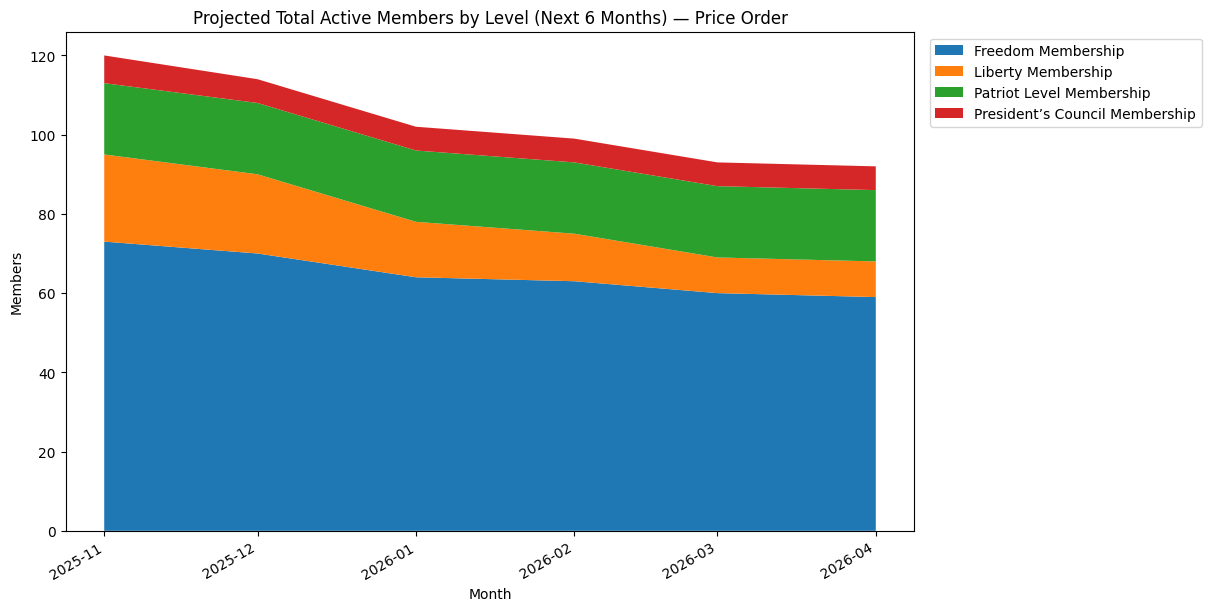

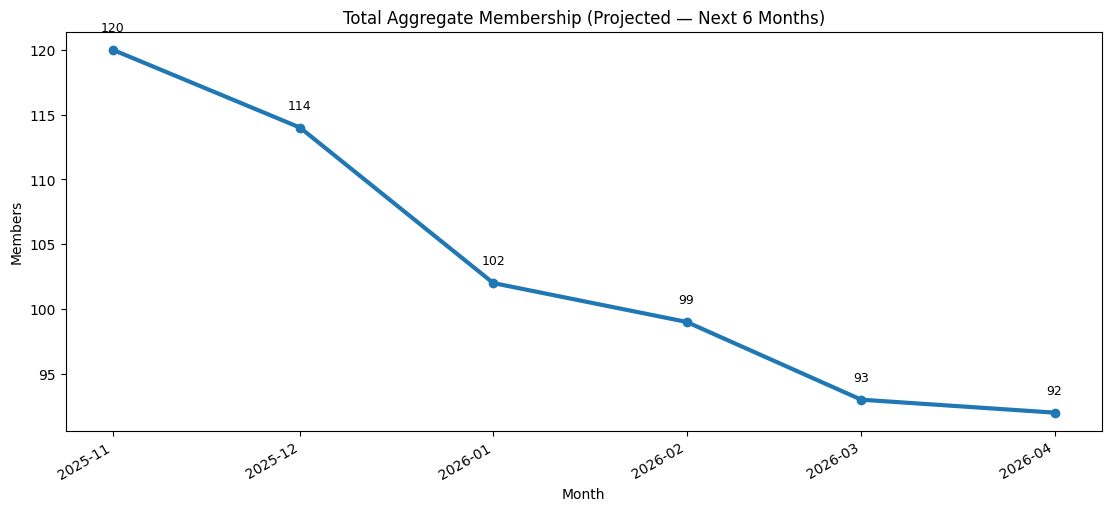

In [60]:
# === ORDER MEMBERSHIP LEVELS BY PRICE ===

LEVEL_ORDER = [
    "Freedom Membership",           # free
    "Liberty Membership",           # $100
    "Patriot Level Membership",     # $250
    "President’s Council Membership" # $1,000
]

# Keep only levels that actually exist in your data, then append any extras at the end
existing_levels = [lvl for lvl in LEVEL_ORDER if lvl in proj_by_level_int.columns]
extras = [lvl for lvl in proj_by_level_int.columns if lvl not in existing_levels]
ordered_levels = existing_levels + extras

# Reindex all relevant tables by this order (columns = levels)
def _recol(d):
    return d.reindex(columns=ordered_levels) if not d.empty else d

proj_by_level_int = _recol(proj_by_level_int)
due_matrix        = _recol(due_matrix)
expected_matrix   = _recol(expected_matrix)
baseline_by_level = baseline_by_level.reindex(ordered_levels, fill_value=0)
hist_rate         = hist_rate.reindex(ordered_levels)

# Redisplay the main tables in price order
display(hist_rate.style.format("{:.2%}").set_caption("Historical Renewal Rate by Membership Level (Price Order)"))
display(baseline_by_level.to_frame("Baseline_Active_Today (Price Order)"))
display(proj_by_level_int.style.format("{:,.0f}").set_caption("Projected Total Active Members by Level — Next 6 Months (Price Order)"))
display(proj_total_int.to_frame())

# Re-draw charts in price order
import matplotlib.pyplot as plt

# Stacked area in price order
fig, ax = plt.subplots(figsize=(12,6), constrained_layout=True)
ax.stackplot(proj_by_level_int.index, proj_by_level_int[ordered_levels].T.values, labels=ordered_levels)
ax.set_title("Projected Total Active Members by Level (Next 6 Months) — Price Order")
ax.set_xlabel("Month"); ax.set_ylabel("Members")
plt.xticks(rotation=30, ha="right")
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1.0))
plt.show()

# Overall total line (unchanged)
fig, ax = plt.subplots(figsize=(11,5), constrained_layout=True)
ax.plot(proj_total_int.index, proj_total_int.values, marker="o", linewidth=3)
ax.set_title("Total Aggregate Membership (Projected — Next 6 Months)")
ax.set_xlabel("Month"); ax.set_ylabel("Members")
for x, v in zip(proj_total_int.index, proj_total_int.values):
    ax.text(x, v + max(1, 0.01*proj_total_int.max()), f"{v:,}", ha="center", va="bottom", fontsize=9)
plt.xticks(rotation=30, ha="right")
plt.show()
